In [9]:
#import mysql
#import pymysql
#import mysql.connector
#from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [8]:
%pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install Lifetimes==0.2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for Lifetimes: filename=Lifetimes-0.2.2.2-py3-none-any.whl size=521850 sha256=1fdab4602493c6a5fc1046b4a3cc9ce442041ddcfa1a315b3dc10764318cc508
  Stored in directory: /Users/shalini/Library/Caches/pip/wheels/04/c1/93/aa670699b6ad1c8743cc25b2aa6ec179260bedcfcf69a9afc7
Successfully built Lifetimes


In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Read .csv file:
# Dataset: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II
df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")
df = df_.copy()
df.shape

##### Data Preparation:
# First look at the data, drop null observations,
# drop negative invoice observations,
# Drop quantity observations that are < 0

df.describe().T
df.dropna(inplace=True)
df.isnull().sum()
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [14]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity") # aykırı değerleri çeyrekliklerde olan değerlere baskılama işlemi
replace_with_thresholds(df, "Price")
df.describe().T


,count,mean,min,25%,50%,75%,max,std
Quantity,354345.0000,10.6769,1.0000,2.0000,4.0000,12.0000,248.5000,22.0755
InvoiceDate,354345,2011-07-11 08:05:04.229606656,2010-12-01 08:26:00,2011-04-07 11:40:00,2011-07-31 15:31:00,2011-10-23 13:49:00,2011-12-09 12:49:00,NaN
Price,354345.0000,2.8150,0.0000,1.2500,1.9500,3.7500,31.5600,2.9206
Customer ID,354345.0000,15552.4362,12346.0000,14194.0000,15522.0000,16931.0000,18287.0000,1594.5460
TotalPrice,354345.0000,18.8520,0.0000,4.1600,10.2000,17.7000,3268.5750,50.0432


In [15]:
##### Accessing and Suppressing Outliers:



###### BGNBD MODEL PREPARATION:

# recency represents the age of the customer when they made their most recent purchases. / weekly
# This is equal to the duration between a customer’s first purchase and their latest purchase.
# T: Customer's age. Weekly. (Calculated upon the date of first transaction of the customer.)
# frequency: Number of repatative transactions (frequency>1)
# monetary_value: Average profit per purchase

# Let's choose a region: UK!
df = df[df["Country"] == "United Kingdom"]
df.head()
df.shape
df["Country"].nunique()

# Data Preparation for BGNBD
df["TotalPrice"] = df["Quantity"] * df["Price"]
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

cltv_df = df.groupby("Customer ID").agg({"InvoiceDate": [lambda date: ((date.max() - date.min()).days) / 7,
                                                         lambda date: ((today_date - date.min()).days) / 7],
                                         "Invoice": lambda freq: freq.nunique(),
                                         "TotalPrice": lambda TotalPrice: TotalPrice.sum()})
cltv_df.head()
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary_value"]

# Expressing monetary value as average profit per purchase
cltv_df["monetary_value"] = cltv_df["monetary_value"] / cltv_df["frequency"]

# Choosing monetary values greater than zero
cltv_df = cltv_df[cltv_df["monetary_value"] > 0]

# frequency must be greater than 1.
cltv_df = cltv_df[(cltv_df["frequency"] > 1)]
cltv_df.describe().T
(cltv_df["frequency"]<1).value_counts()



frequency
False    2570
Name: count, dtype: int64

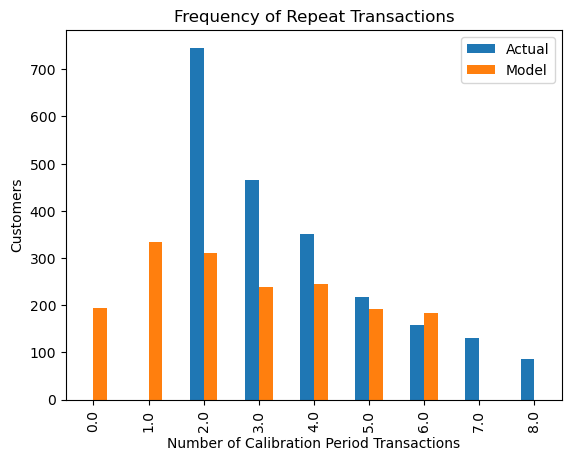

Customer ID                          recency                        T                    frequency               monetary_value                      expected_purc_1_week                 exp_avg_profit                        clv                        scaled_clv               
              count       mean           sum   count    mean        sum count    mean        sum     count    mean   sum          count     mean         sum                count   mean      sum          count     mean         sum count      mean          sum      count   mean     sum
Segment                                                                                                                                                                                                                                                                                     
D               643 15706.1788 10099073.0000     643 22.0671 14189.1429   643 40.5090 26047.2857       643  3.0684  1973            643 177.4250 114084.2713                  643 0.0710  45.6644            643 192.2210 123598.0776   643  269.4670  173267.3118        643 0.0031  2.0229
C               642 15521.4050  9964742.0000     642 30.8364 19797.0000   642 38.1656 24502.2857       642  3.9907  2562            642 260.6893 167362.5081                  642 0.1195  76.7253            642 278.0698 178520.7809   642  710.8237  456348.8182        642 0.0083  5.3280
B               642 15596.3364 10012848.0000     642 29.8389 19156.5714   642 35.1170 22545.1429       642  5.4548  3502            642 351.9869 225975.5615                  642 0.1614 103.6310            642 370.4956 237858.1615   642 1271.3529  816208.5590        642 0.0148  9.5295
A               643 15390.8383  9896309.0000     643 31.4606 20229.1429   643 34.5192 22195.8571       643 11.2924  7261            643 586.3022 376992.3231                  643 0.2724 175.1616            643 608.6966 391391.9252   643 3806.3490 2447482.3888        643 0.0444 28.5751

In [16]:
####### BGNBD MODEL:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

plot_period_transactions(bgf)
plt.show()

# Ex: the 10 customers we expect the most to purchase in a week:

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df["frequency"],
                                              cltv_df["recency"],
                                              cltv_df["T"])

cltv_df.head()
cltv_df.sort_values(by="expected_purc_1_week", ascending=False).head(10)


###### GAMMA GAMMA MODEL:

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"], cltv_df["monetary_value"])

cltv_df["exp_avg_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                                                    cltv_df["monetary_value"])

cltv_df.sort_values("exp_avg_profit", ascending=False)


###################
#  Finally! Calculation of CLTV with BG-NBD and GG model.
###################

# Ex: For 6 months of time prediction

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary_value"],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)

cltv = cltv.reset_index()

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

# Let's see the final table:

cltv_final.sort_values(by="clv", ascending=False).head(10)

###### Segmentation of Customers:

# 1. Scaling for better insight of dataframe:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

# 2. Segmentation:
cltv_final["Segment"] = pd.qcut(cltv_final["scaled_clv"], 4, ["D", "C", "B", "A"])
cltv_final.head()

cltv_final.groupby("Segment").agg(["count", "mean", "sum"])